import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
import random

In [2]:
with open('dataset.pickle','rb') as f:
    data = pickle.load(f)

train_data = data['train']
val_data = data['val']

### NUMBER OF EXAMPLES AND MAXIMUM VALUES

In [3]:
print(f"Train examples {len(train_data)}. Validation examples {len(val_data)}.")

Train examples 232. Validation examples 75.


### GENERATE SAMPLE IMAGES

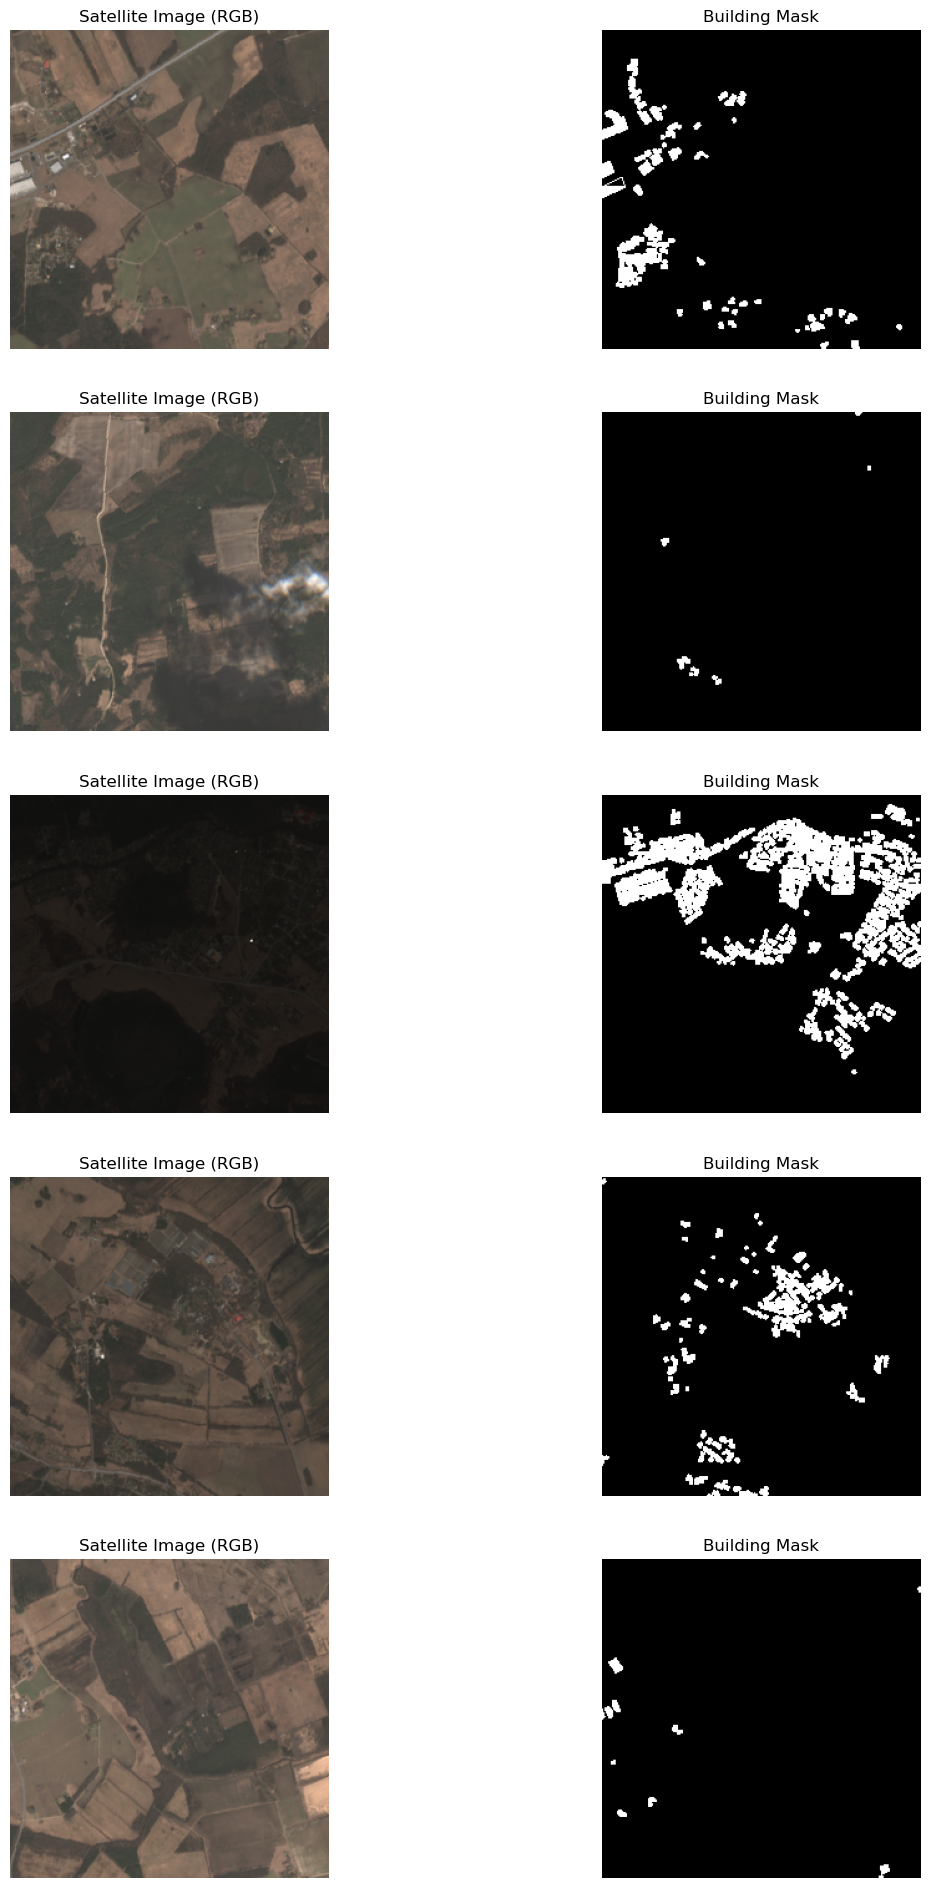

In [4]:
samples_to_gen = 5
samples = np.random.choice(np.arange(0, 232), size=samples_to_gen, replace=False).tolist()

fig, axes = plt.subplots(samples_to_gen, 2, figsize=(14, 24))

for index, value in enumerate(samples): 

    image, mask = train_data[value]['image']/train_data[value]['image'].max(), train_data[value]['mask']
    image = image[:, :, ::-1]
    # Create a plot with two subplots
    axes[index, 0].imshow(image, cmap='BuGn_r')
    axes[index, 0].set_title('Satellite Image (RGB)')
    axes[index, 0].axis('off')

    # Display the binary mask
    axes[index, 1].imshow(mask, cmap='gray')
    axes[index, 1].set_title('Building Mask')
    axes[index, 1].axis('off')

plt.show()


### Augmentation

We have a very small dataset, and it's hard to have to generalise based on it. We'll use the dynamic augmentation, which will apply changes to the model during each batch call. 

In [5]:
def adjust_brightness_contrast(image):
    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.5, 1.5)  # Adjust to your needs
    image = enhancer.enhance(brightness_factor)
    
    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    contrast_factor = random.uniform(0.5, 1.5)  # Adjust to your needs
    image = enhancer.enhance(contrast_factor)
    
    return image

def random_flip_rotate(image, mask):
    # Randomly flip both image and mask
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Randomly rotate both image and mask
    angle = random.choice([0, 90, 180, 270])
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    
    return image, mask


def random_scaling_cropping(image, mask, scale_range=(0.8, 1.2), crop_size=(256, 256)):
    # Scale both image and mask
    scale_factor = random.uniform(*scale_range)
    new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    image = image.resize(new_size, Image.LANCZOS)
    mask = mask.resize(new_size, Image.NEAREST)  # NEAREST for masks to avoid interpolation
    
    # Crop both image and mask
    left = random.randint(0, max(0, new_size[0] - crop_size[0]))
    top = random.randint(0, max(0, new_size[1] - crop_size[1]))
    image = image.crop((left, top, left + crop_size[0], top + crop_size[1]))
    mask = mask.crop((left, top, left + crop_size[0], top + crop_size[1]))
    
    return image, mask


def add_noise(image, noise_factor=0.05):
    img_array = np.array(image)
    noise = np.random.normal(scale=noise_factor, size=img_array.shape)
    noisy_img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img_array)

def color_jitter(image):
    enhancer = ImageEnhance.Color(image)
    color_factor = random.uniform(0.5, 1.5)  # Adjust to your needs
    image = enhancer.enhance(color_factor)
    return image

##### Augmentation classes

In [6]:
from torch.utils.data import Dataset

class CustomAugmentation:
    def __call__(self, image, mask):
        # Apply augmentations in sync for both image and mask
        image, mask = random_flip_rotate(image, mask)
        image, mask = random_scaling_cropping(image, mask)
        
        # Other augmentations applied only to the image (e.g., color augmentations, noise)
        image = adjust_brightness_contrast(image)
        image = add_noise(image)
        image = color_jitter(image)
        
        return image, mask

class AugmentedDataset(Dataset):
    def __init__(self, image_arrays, mask_arrays, transform=None):
        self.image_arrays = image_arrays
        self.mask_arrays = mask_arrays
        self.transform = transform

    def __len__(self):
        return len(self.image_arrays)

    def __getitem__(self, idx):
        image_array = self.image_arrays[idx]
        mask_array = self.mask_arrays[idx]

        # Ensure correct data type (assuming input is normalized between 0 and 1)
        image_array = (image_array * 255).astype(np.uint8)  
        mask_array = (mask_array * 255).astype(np.uint8)

        # Convert NumPy arrays to PIL Images
        image = Image.fromarray(image_array)
        mask = Image.fromarray(mask_array)

        if self.transform:
            # Apply transformations to both image and mask
            image, mask = self.transform(image, mask)
            
        # Convert back to tensors after transformations
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        return image, mask



### Baseline approach

With 232 images in the training dataset, and 75 in the validation dataset, it's hard (not to mention expensive) to train a convolutional network from scratch. Therefore, we will prototype a solution using transfer learning. The type of Deep Learning models we use for such tasks are Convolutional Neural Networks. One of the most commonly used models is U-Net, which we will use here.

We will use the EfficientNet-B0 as the encoder. It has short inference time, and it doesn't many parameters. This will prevent our model from overfitting, which would happen on a larger dataset, such as ResNet18 or ResNet34. 


In [7]:
import torch
from torch import nn
import torch.optim as optim
import timm
import torchvision.models as models

In [8]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class UNetEfficientNetB0(nn.Module):
    def __init__(self, out_channels):
        super(UNetEfficientNetB0, self).__init__()
        
        # Define the model using SMP with EfficientNet-B0 encoder
        self.model = smp.Unet(
            encoder_name="efficientnet-b0",    # Choose EfficientNet-B0 as the encoder
            encoder_weights="imagenet",        # Use pre-trained ImageNet weights
            in_channels=3,                     # Input channels (3 for RGB images)
            classes=out_channels               # Output channels (e.g., 1 for binary segmentation)
        )

    def forward(self, x):
        # Forward pass through the U-Net model
        return self.model(x)

# Example usage
model = UNetEfficientNetB0(out_channels=1)

In [9]:
import torch

# Use CPU for this specific task.
device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the mix of Focal and Dice loss to focus better on classifying harder examples. 
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to logits if needed
        inputs = torch.sigmoid(inputs)
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Compute Focal Loss
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        probs = inputs
        focal_loss = self.alpha * ((1 - probs) ** self.gamma) * targets * bce_loss + \
                     (1 - self.alpha) * (probs ** self.gamma) * (1 - targets) * bce_loss
        focal_loss = focal_loss.mean()
        
        # Compute Dice Loss
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        # Combine Focal Loss and Dice Loss
        combined_loss = focal_loss + dice_loss
        
        return combined_loss


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import logging


train_images_transform = [(x['image']/x['image'].max())[:, :, ::-1] for x in train_data]
train_masks = [x['mask'] for x in train_data]

# Define your augmentation pipeline
transform = CustomAugmentation()

train_dataset = AugmentedDataset(train_images_transform, train_masks, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0)

# Define loss function and optimizer
criterion = FocalDiceLoss(alpha=0.25, gamma=2, smooth=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize an empty list to store epoch losses
epoch_losses = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            pbar.update(1)

    # Calculate and save average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)

    # Optionally, print loss per epoch (can be commented out if not needed)
    print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}')

# Print all epoch losses after training
print("All Epoch Losses: ", epoch_losses)

# Optionally, save the losses to a file (e.g., CSV)
with open('epoch_losses.txt', 'w') as f:
    for loss in epoch_losses:
        f.write(f"{loss}\n")

Epoch 1/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:03<00:02,  2.38s/batch][W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:04<00:00,  2.36s/batch]


Epoch 1 Loss: 0.9932


Epoch 2/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [04:01<00:03,  3.13s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [04:02<00:00,  3.11s/batch]


Epoch 2 Loss: 0.9350


Epoch 3/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [11:43<00:02,  2.78s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [11:44<00:00,  9.04s/batch]


Epoch 3 Loss: 0.8953


Epoch 4/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.42s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 4 Loss: 0.8455


Epoch 5/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 5 Loss: 0.8221


Epoch 6/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 6 Loss: 0.7668


Epoch 7/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 7 Loss: 0.7132


Epoch 8/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:04<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:05<00:00,  2.38s/batch]


Epoch 8 Loss: 0.6937


Epoch 9/30:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 9 Loss: 0.6891


Epoch 10/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:04<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:05<00:00,  2.38s/batch]


Epoch 10 Loss: 0.6695


Epoch 11/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.43s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 11 Loss: 0.6520


Epoch 12/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 12 Loss: 0.6376


Epoch 13/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:04<00:02,  2.40s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:05<00:00,  2.38s/batch]


Epoch 13 Loss: 0.6271


Epoch 14/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]


Epoch 14 Loss: 0.6206


Epoch 15/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:09<00:02,  2.49s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:10<00:00,  2.44s/batch]


Epoch 15 Loss: 0.6080


Epoch 16/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:11<00:02,  2.43s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:12<00:00,  2.46s/batch]


Epoch 16 Loss: 0.6016


Epoch 17/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:07<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.41s/batch]


Epoch 17 Loss: 0.5980


Epoch 18/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 18 Loss: 0.6110


Epoch 19/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:04<00:02,  2.38s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:04<00:00,  2.37s/batch]


Epoch 19 Loss: 0.6094


Epoch 20/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:03<00:02,  2.37s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:04<00:00,  2.37s/batch]


Epoch 20 Loss: 0.5808


Epoch 21/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:02<00:02,  2.35s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:02<00:00,  2.35s/batch]


Epoch 21 Loss: 0.5812


Epoch 22/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:03<00:02,  2.46s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:04<00:00,  2.36s/batch]


Epoch 22 Loss: 0.5823


Epoch 23/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:04<00:02,  2.42s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:05<00:00,  2.38s/batch]


Epoch 23 Loss: 0.6059


Epoch 24/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:07<00:02,  2.49s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:08<00:00,  2.42s/batch]


Epoch 24 Loss: 0.5692


Epoch 25/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 25 Loss: 0.5804


Epoch 26/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.44s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 26 Loss: 0.5773


Epoch 27/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.42s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 27 Loss: 0.5734


Epoch 28/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.39s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 28 Loss: 0.5611


Epoch 29/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:06<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:07<00:00,  2.40s/batch]


Epoch 29 Loss: 0.5763


Epoch 30/30:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 77/78 [03:05<00:02,  2.41s/batch]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [03:06<00:00,  2.39s/batch]

Epoch 30 Loss: 0.5565
All Epoch Losses:  [0.9931919767424978, 0.9350172168221967, 0.8952809500283209, 0.8454966298465071, 0.8221422101146189, 0.766756716344891, 0.7131749201437523, 0.6937096151041573, 0.6890837970221865, 0.669493502583997, 0.6520212270833295, 0.6376348085187632, 0.6271444322734043, 0.6205805340974495, 0.6079501396623151, 0.6016458307617697, 0.5980414685247273, 0.6110073207267399, 0.6093878883483081, 0.5808242288386, 0.5811971600713401, 0.582330863280543, 0.6059056422833738, 0.5691790989246862, 0.5803666408976604, 0.5772663100526251, 0.5733860203161322, 0.5610868208881082, 0.5763432847271706, 0.5565427441535324]


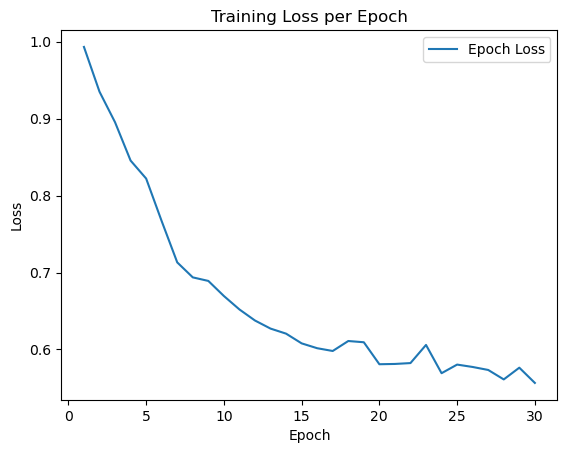

In [12]:
# Optionally, plot the losses after training
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

### Saving the model




In [13]:
torch.save(model.state_dict(),'model_rade_njezic.pth')
print("The model is saved.")

The model is saved.


### Validation and Training

In [14]:
# Dataset normalisation
val_data = [((x['image']/x['image'].max())[:, :, ::-1], x['mask']) for x in val_data]

# Issues happened with strides, copying fixes it.
val_data = [(x[0].copy(), x[1].copy()) for x in val_data_transform]

# From GBR to RBG
val_data = [(x[0].transpose(2, 0, 1), x[1]) for x in val_data_transform]
val_loader = DataLoader(val_data_transform, batch_size=3, shuffle=True, num_workers=0)



In [15]:
# Define the IoU calculation function
def calculate_iou(pred, target, threshold=0.5):
    """Compute IoU score given predicted and target binary masks."""
    # Apply threshold to get binary mask predictions
    pred = (pred > threshold).float()

    # Compute intersection and union
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3)) - intersection

    # Avoid division by zero
    iou = intersection / (union + 1e-6)
    return iou.mean().item()

# Function to evaluate and calculate IoU on the entire validation set
def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validating', unit='batch') as pbar:
            for images, masks in val_loader:

                # Collect all predictions and masks
                all_preds.append(outputs.cpu())
                all_masks.append(masks.cpu())
                pbar.update(1)

    # Concatenate all predictions and masks
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    # Calculate IoU on the entire validation set
    iou = calculate_iou(all_preds, all_masks)
    print(f"IoU on entire validation set: {iou:.4f}")
    return iou, all_preds, all_masks

# Example usage:
iou, all_preds, all_masks =evaluate_model(model, val_loader, device)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.80batch/s]

IoU on entire validation set: 0.3538
IoU is equal to <_io.TextIOWrapper name='epoch_losses.txt' mode='w' encoding='UTF-8'>.


Iou between predicted and true mask 0.36. The photo is 10.
Iou between predicted and true mask 0.27. The photo is 53.
Iou between predicted and true mask 0.19. The photo is 58.
Iou between predicted and true mask 0.38. The photo is 43.
Iou between predicted and true mask 0.27. The photo is 30.


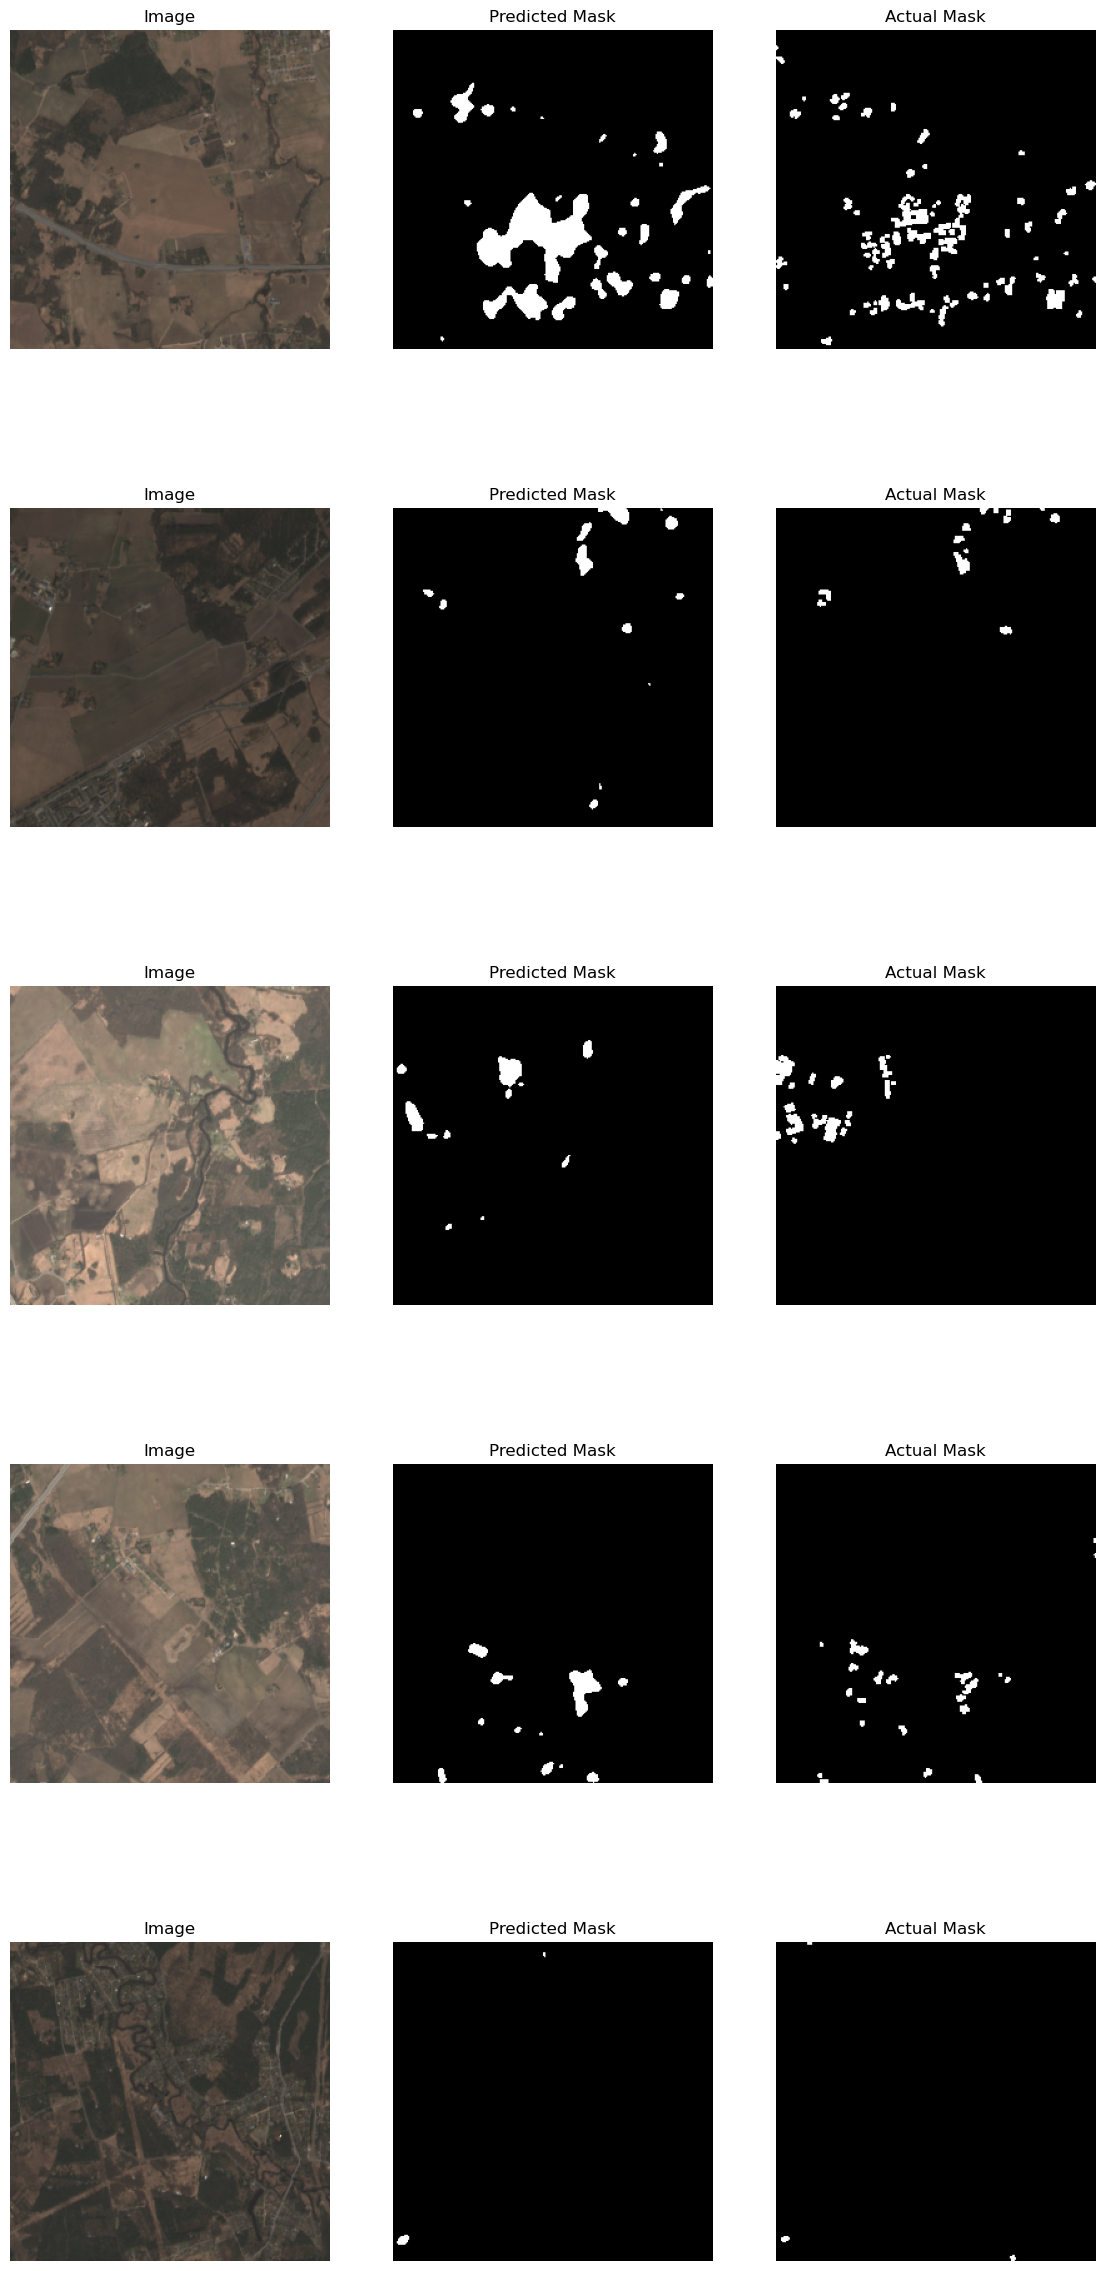

In [16]:
samples_to_gen = 5
samples = np.random.choice(np.arange(0, 75), size=samples_to_gen, replace=False).tolist()
fig, axes = plt.subplots(samples_to_gen, 3, figsize=(14, 30))
ious = []
for index, value in enumerate(samples): 

    image, pred_mask, true_mask = (val_data[value]['image']/val_data[value]['image'].max())[:, :, ::-1], all_preds[value][0], all_masks[value][0]
    
    # Calculate intersection and union
    intersection = ((pred_mask > 0.5).float() * true_mask).sum()
    union = ((pred_mask > 0.5).float() + true_mask).clamp(0, 1).sum()

    # IoU calculation
    iou = intersection / union
    
    print(f"Iou between predicted and true mask {iou.item():.2f}. The photo is {value}.")
    # Create a plot with three subplots
    axes[index, 0].imshow(image)
    axes[index, 0].set_title('Image')
    axes[index, 0].axis('off')

    axes[index, 1].imshow(pred_mask > 0.5, cmap='gray')
    axes[index, 1].set_title('Predicted Mask')
    axes[index, 1].axis('off')

    # Display the binary mask
    axes[index, 2].imshow(true_mask, cmap='gray')
    axes[index, 2].set_title('Actual Mask')
    axes[index, 2].axis('off')


plt.show()


### Distributions between the masks

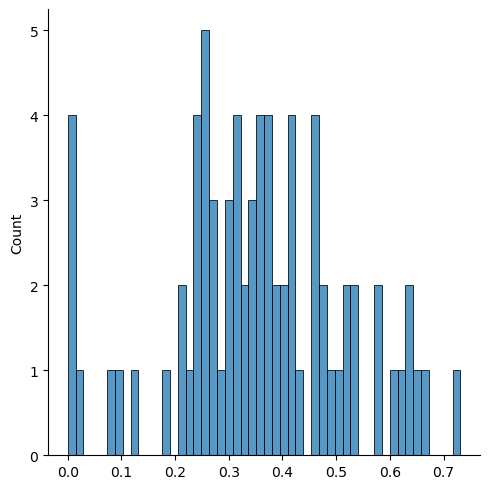

In [17]:
ious = []
for pred_mask_, real_mask_ in zip(all_preds,all_masks):
    pred_mask, true_mask = pred_mask_[0], real_mask_[0]
    # Calculate intersection and union
    intersection = ((pred_mask > 0.5).float() * true_mask).sum()
    union = ((pred_mask > 0.5).float() + true_mask).clamp(0, 1).sum()

    # IoU calculation
    iou = intersection / union
    ious.append(iou.item())

sns.displot(ious, bins=50)

Looking at the generated images, we notice that the issues mostly appear for the images with the small and not visible masked area. In the photos, we have IoU equal to 0.